# Finetune our GPT Language Model
In the following, we will see how to fine-tune GPT on a language modeling tasks. 

1. **Causal language modeling:** the model has to predict the next token in the sentence.

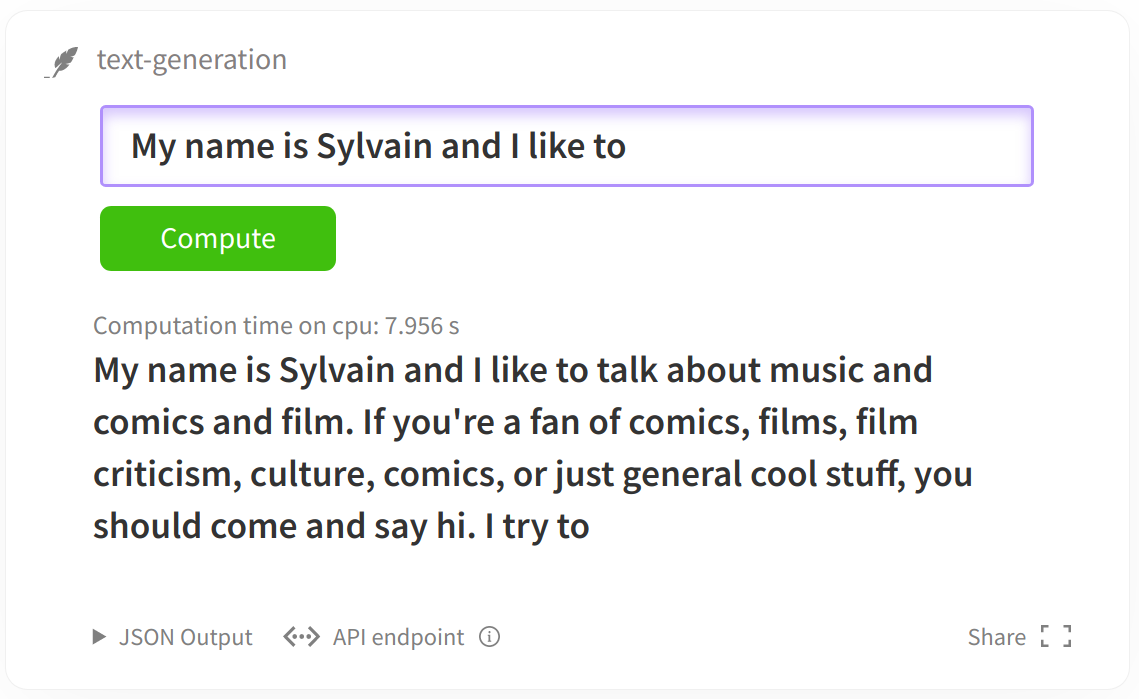

2. **Masked language modeling:** the model has to predict some tokens that are masked in the input.

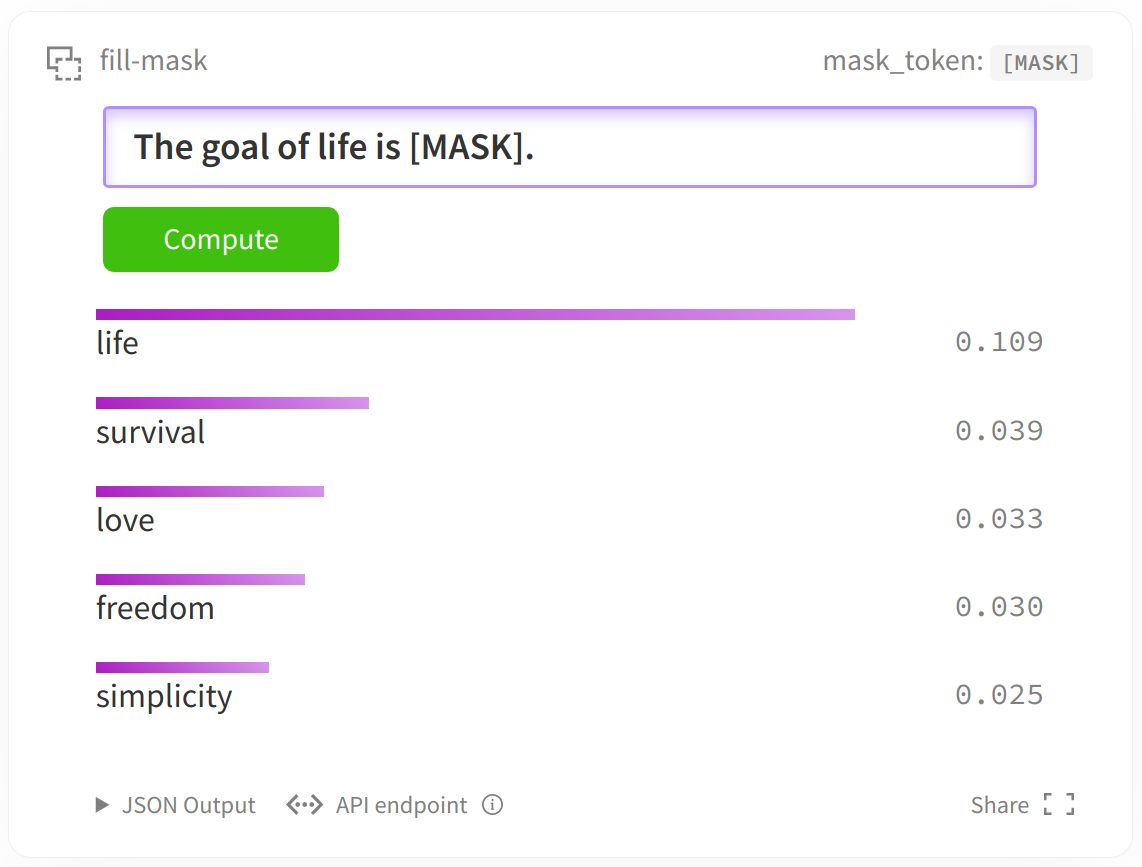

## Preparing the dataset
For each of those tasks, we will use the Wikitext 2 dataset as an example. You can load it very easily with the Datasets library.

In [11]:
from datasets import load_dataset

datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
datasets["train"][10]

Found cached dataset wikitext (/home/zonghang/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

## Causal Language modeling
For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:

```
end of text 1 [BOS_TOKEN] beginning of text 2
```

We will use the OpenAI GPT model for this example. You can pick any of the [checkpoints listed here](https://huggingface.co/models?other=causal-lm) instead:

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)

We can now call the tokenizer on all our texts. This is very simple, using the map method from the Datasets library. 

First we define a function that call the tokenizer on our texts:

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our datasets object, using <code>batched=True</code> and 4 processes to speed up the preprocessing.

We won't need the text column afterward, so we discard it.

In [14]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])
print(tokenized_datasets["train"][1])

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

{'input_ids': [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain <code>block_size</code>. 

First, we grab the maximum length our model was pretrained with. This might be too big to fit in our GPU RAM, so here we take a bit less at just 128.

In [15]:
# block_size = tokenizer.model_max_length  # output: 512
block_size = 128

Then we write the preprocessing function that will group our texts:

In [16]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [17]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

' game and follows the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Oz'

Now the samples contain chunks of <code>block_size</code> contiguous tokens, potentially spanning over several of our original texts.

Next, we define our OpenAI GPT model:

In [18]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained('distilgpt2')
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

And some TrainingArguments:

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    f"openai-gpt-finetuned-wikitext2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01
)
training_args

TrainingArguments(
_n_gpu=2,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_toke

Then, we can pass along all of those to the Trainer class:

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
)

Start training now !

In [21]:
trainer.train()

/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,3.797700,3.681150
2,3.696400,3.659145
3,3.648200,3.653173


/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/zonghang/.conda/envs/gpt/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to 

TrainOutput(global_step=3501, training_loss=3.735593668361011, metrics={'train_runtime': 521.9117, 'train_samples_per_second': 107.294, 'train_steps_per_second': 6.708, 'total_flos': 1829011929956352.0, 'train_loss': 3.735593668361011, 'epoch': 3.0})